# Simulated Cancer Omics dataset using InterSim CRAN package

## Import packages and IntegrAO code

In [13]:
import numpy as np
import pandas as pd
import snf
from sklearn.cluster import spectral_clustering
from sklearn.metrics import v_measure_score
import matplotlib.pyplot as plt

import sys
import os
import argparse
import torch

import umap
from sklearn.model_selection import train_test_split

In [2]:
# Add the parent directory of "integrao" to the Python path
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from integrao.dataset import GraphDataset
from integrao.main import dist2
from integrao.integrater import integrao_integrater

## Set hyperparameters

In [3]:
torch.cuda.is_available()

True

In [7]:
# Hyperparameters
neighbor_size = 20
embedding_dims = 64
fusing_iteration = 30
normalization_factor = 1.0
alighment_epochs = 1000
beta = 1.0
mu = 0.5


dataset_name = 'cancer omics'
cluster_number = 15

## Read data

In [5]:
testdata_dir = os.path.join(module_path, "data/omics/")

methyl_ = os.path.join(testdata_dir, "omics1.txt")
expr_ = os.path.join(testdata_dir, "omics2.txt")
protein_ = os.path.join(testdata_dir, "omics3.txt")
truelabel = os.path.join(testdata_dir, "clusters.txt")


methyl = pd.read_csv(methyl_, index_col=0, delimiter="\t")
expr = pd.read_csv(expr_, index_col=0, delimiter="\t")
protein = pd.read_csv(protein_, index_col=0, delimiter="\t")
truelabel = pd.read_csv(truelabel, index_col=0, delimiter="\t")

methyl = np.transpose(methyl)
expr = np.transpose(expr)
protein = np.transpose(protein)
print(methyl.shape)
print(expr.shape)
print(protein.shape)
print(truelabel.shape)
print("finish loading data!")

(500, 367)
(500, 131)
(500, 160)
(500, 2)
finish loading data!


## KNN clustering for clustering cnv, meth and mirna raw features as baseline

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import v_measure_score

# cnv
kmeans = KMeans(n_clusters=cluster_number, random_state=42, n_init='auto').fit(methyl.values)
labels = kmeans.labels_
true_labels = truelabel['cluster.id'].tolist()
score = v_measure_score(true_labels, labels)
print("methyl raw features kmeans clustering NMI: {}".format(score))

# meth
kmeans = KMeans(n_clusters=cluster_number, random_state=42, n_init='auto').fit(expr.values)
labels = kmeans.labels_
true_labels = truelabel['cluster.id'].tolist()
score = v_measure_score(true_labels, labels)
print("expr raw features kmeans clustering NMI: {}".format(score))

# mirna
kmeans = KMeans(n_clusters=cluster_number, random_state=42, n_init='auto').fit(protein.values)
labels = kmeans.labels_
true_labels = truelabel['cluster.id'].tolist()
score = v_measure_score(true_labels, labels)
print("protein raw features kmeans clustering NMI: {}".format(score))

methyl raw features kmeans clustering NMI: 0.4092647077881033
expr raw features kmeans clustering NMI: 0.7651290634507789
protein raw features kmeans clustering NMI: 0.868987364136353


## Random sub-sample the omics dataset to create an incomplete dataset

In [14]:
ratio = 0.7

full_indices = range(len(methyl))
unique_indices, common_indices = train_test_split(full_indices, test_size=ratio)

w1w2_indices, w3_indices = train_test_split(unique_indices, test_size=0.33)
w1_indices, w2_indices = train_test_split(w1w2_indices, test_size=0.5)

w1_full_indices = common_indices + w1_indices
w2_full_indices = common_indices + w2_indices
w3_full_indices = common_indices + w3_indices

methyl_temp = methyl.iloc[w1_full_indices]
expr_temp = expr.iloc[w2_full_indices]
protein_temp = protein.iloc[w3_full_indices]


## IntegrAO integration

In [15]:
# Initialize integrater
integrater = integrao_integrater(
    [methyl_temp, expr_temp, protein_temp],
    dataset_name,
    neighbor_size=neighbor_size,
    embedding_dims=embedding_dims,
    fusing_iteration=fusing_iteration,
    normalization_factor=normalization_factor,
    alighment_epochs=alighment_epochs,
    beta=beta,
    mu=mu,
)
# data indexing
fused_networks = integrater.network_diffusion()
embeds_final, S_final, model = integrater.unsupervised_alignment()

labels = spectral_clustering(S_final, n_clusters=cluster_number)

true_labels = truelabel.sort_values('subjects')['cluster.id'].tolist()

score_all = v_measure_score(true_labels, labels)
print("IntegrAO for clustering union 500 samples NMI score: ", score_all)

Start indexing input expression matrices!
Common sample between view0 and view1: 350
Common sample between view0 and view2: 350
Common sample between view1 and view2: 350
Neighbor size: 20
Start applying diffusion!
Diffusion ends! Times: 15.066577911376953s
Starting unsupervised exmbedding extraction!
Dataset 0: (400, 367)
Dataset 1: (400, 131)
Dataset 2: (400, 160)
epoch 0: loss 30.054597854614258, align_loss:0.775736
epoch 100: loss 20.709983825683594, align_loss:0.151950
epoch 200: loss 1.092381477355957, align_loss:0.082980
epoch 300: loss 1.0914002656936646, align_loss:0.082236
epoch 400: loss 1.0902798175811768, align_loss:0.081427
epoch 500: loss 1.0890438556671143, align_loss:0.080614
epoch 600: loss 1.0877360105514526, align_loss:0.079772
epoch 700: loss 1.0863633155822754, align_loss:0.078964
epoch 800: loss 1.0849252939224243, align_loss:0.078173
epoch 900: loss 1.0834227800369263, align_loss:0.077401
Manifold alignment ends! Times: 56.45441031455994s
IntegrAO for clustering

## UMAP plot of the integrated embeddings

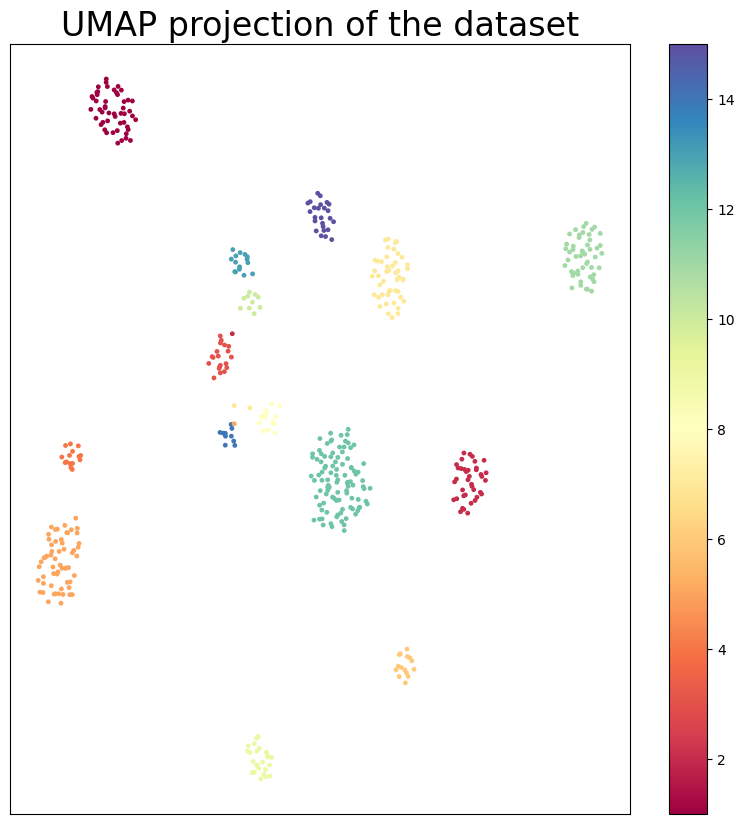

In [16]:
import umap

# umap visualization of embeddings with hue as labels
reducer = umap.UMAP(n_neighbors=30, min_dist=1.0, spread=1.0)
embedding = reducer.fit_transform(embeds_final.values)
plt.figure(figsize=(10, 10))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=true_labels,
    s=6,
    cmap="Spectral",
    alpha=1.0,
)
plt.setp(plt.gca(), xticks=[], yticks=[])
plt.title("UMAP projection of the dataset", fontsize=24)
plt.colorbar()
plt.show()